In [2]:
#matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
lateststr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The most recent date is {lateststr} ')

The most recent date is ('2017-08-23',) 


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame and set the index to the date column


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data

latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any') # clean up non value entries
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()



,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


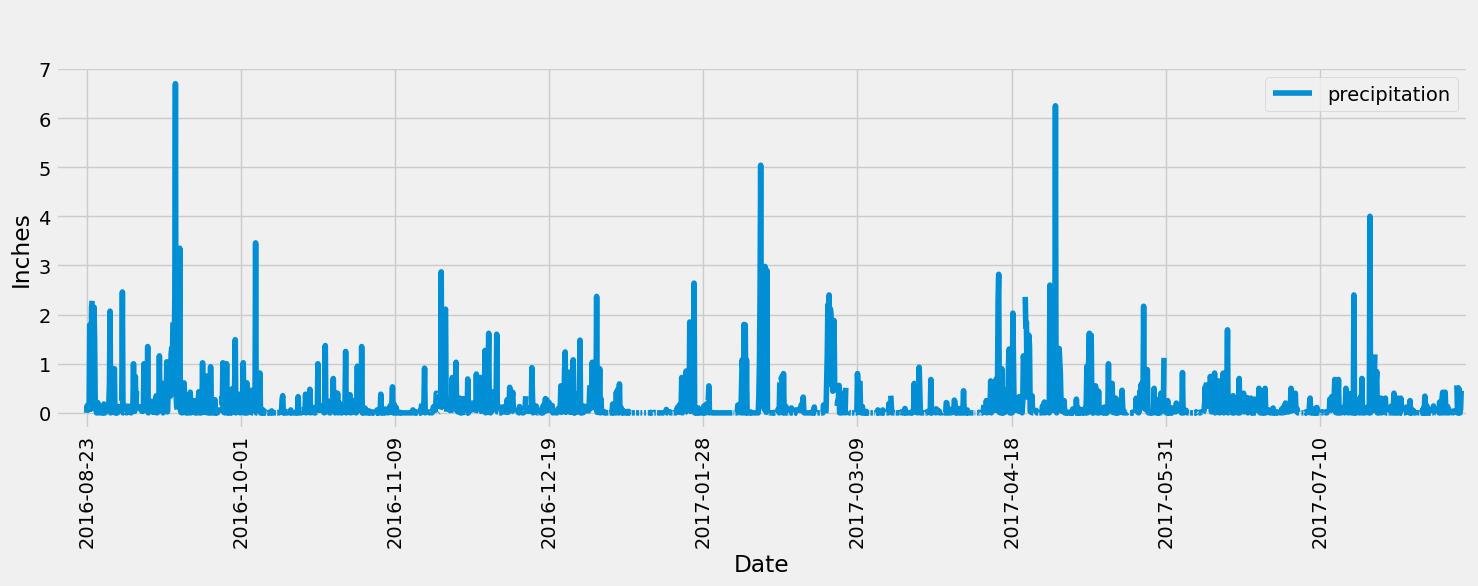

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).scalar()

### Last one year mark in the dataset
One_year_mark = dt.datetime.strptime(last_date, "%Y-%m-%d")-dt.timedelta(days=366)

### Perform a query to retrieve the data and precipitation scores
#sql alchemy understands the DateTime dtype and converts that to string implicitly!!
last_one_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(
    (Measurement.date >= One_year_mark)).order_by(Measurement.date).all()

### Save the query results as a Pandas DataFrame and set the index to the date column
last_one_year_prcp_DF = pd.DataFrame(last_one_year_prcp, columns=['Date','precipitation'])
last_one_year_prcp_DF.set_index('Date', inplace=True)
#There are 208 NUll prcp values

### Sort the dataframe by date (Though the data is sorted initially, creating DF from the data changes the order)
last_one_year_prcp_DF.sort_index(inplace=True)


### Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,6))
_=last_one_year_prcp_DF.plot(ax=ax)


xticks = np.arange(0,len(last_one_year_prcp_DF)+1,250)
xticklabels = last_one_year_prcp_DF.index[xticks].to_list()
plt.ylabel("Inches")
plt.suptitle(f" ")
plt.xlim((-50,len(last_one_year_prcp_DF)+10))
plt.xticks(xticks, xticklabels, rotation=90)
plt.tight_layout()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestationdata = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactivestationdata

(54.0, 85.0, 71.66378066378067)

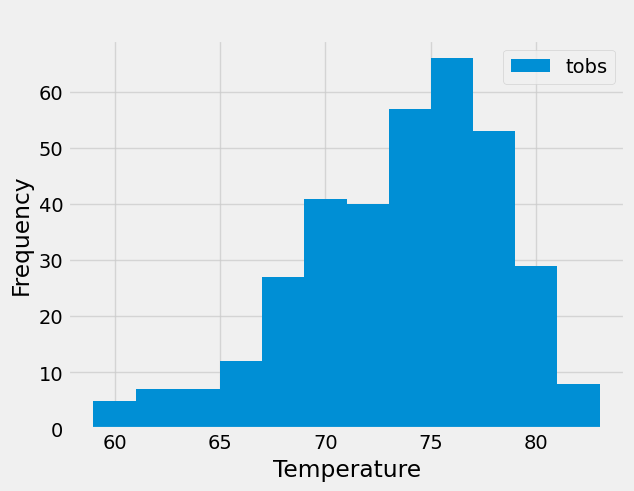

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == activestations[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f" ")
plt.legend()

# Close session

In [19]:
# Close Session
session.close()